In [1]:
%matplotlib inline
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np

# Discount Data

In [300]:
discount_data = pd.read_csv('data/DIM_DISCOUNT.csv', na_values='NULL', sep=',',
                            usecols=['discountID', 'nameMaster', 'posPercent'], dtype={})
discount_data.head(3)

,discountID,nameMaster,posPercent
0,6268161,AAA DINING CARD,50
1,6268163,AMEX DINING CARD,50
2,6268165,CHILD ITEM,50


In [301]:
name_percent = discount_data.groupby('nameMaster')['posPercent'].mean().sort_values(ascending=False)
name_percent[name_percent>0]

nameMaster
BREAKFAST COUPON            100
MANAGER COMP 100%           100
MANAGER MEAL 100%           100
Item Discount               100
PARTY 100% Disco            100
AMENITY COUPON              100
DESIGNATED DRIVER DISCOU    100
SOUVENIR SODA REFILL        100
SOUV POPCORN REFILL         100
LOAF HH DISCOUNT             50
AAA DINING CARD              50
AMEX DINING CARD             50
RED ZONE COUPON              50
CHILD ITEM                   50
1ST & 10 COUPON              50
EMPLOYEE MEAL                50
50% PRE GM H & I             50
AAA DISCOUNT                 20
MILITARY DISCOUNT            20
MLB EMPLOYEE 20%             20
VENUE 20%                    20
TEAM CARD 15%                15
SEASON TICKET DISCOUNT       15
VIP DISCOUNT                 10
VENUE EMPLOYEE               10
10% CITIZEN DEBIT DISC.      10
LP SLIP OWNER 10%            10
CITI DISCOUNT 10%            10
Name: posPercent, dtype: int64

# TENDER

In [295]:
tender_data = pd.read_csv('data/DIM_TENDER_MEDIA.csv', na_values='NULL', sep=',', 
                          usecols=['tenderMediaID', 'name'], dtype={})
tender_data.head(3)

,tenderMediaID,name
0,6272607,VISA
1,6272609,MASTERCARD
2,6272611,DISCOVER


# Menu data

In [2]:
menu_data = pd.read_csv('data/DIM_MENU_ITEM.csv', na_values='NULL', sep=',', 
                        dtype={},
                        usecols=['menuItemID', 'menuItemName1', 'majorGroupID'])
menu_data.head(3)

,menuItemID,menuItemName1,majorGroupID
0,8122034,Gluten Free Juic,811998
1,7841299,Buff Chix Stk,811996
2,7726145,Whole Fruit,811996


# Explore FACT DATA

In [3]:
# Parameters:
## chunksize can be a large value to partition the data
## iterator=True returns a TextFileReader object from .read_csv()
## we could then iterate through the chunks
## usecols=[] takes a list of column strings to use in the dataframe.
## dtype reduced the size of each data column considerably when ints were specified
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f')
fact_reader = pd.read_csv('data/FACT_Sites_2017.csv', chunksize=5000, 
                          skip_blank_lines=True, error_bad_lines=False,
                          parse_dates=['transDatetime'], infer_datetime_format=True,
                          iterator=True, dtype={},
                          usecols=['revenueCenterID', 'Location','transDatetime','recordID','uwsID','checkEmployeeID','voidFlag']
                         )

## Sales Calender

In [4]:
%%time
date_groups = pd.DataFrame()
i = 0
fact_reader = pd.read_csv('data/FACT_Sites_2017.csv', chunksize=5000, 
                          skip_blank_lines=True, error_bad_lines=False,
                          parse_dates=['transDatetime'], infer_datetime_format=True,
                          iterator=True, dtype={},
                          usecols=['transDatetime']
                         )
for chunk in fact_reader:
    i += 1
    #Date distribution
    date_group_chunk = chunk.groupby([chunk.transDatetime.dt.weekday,chunk.transDatetime.dt.month]).size().unstack()
    date_groups = date_groups.add(date_group_chunk, fill_value=0)

CPU times: user 1min 29s, sys: 16.9 s, total: 1min 46s
Wall time: 1min 51s


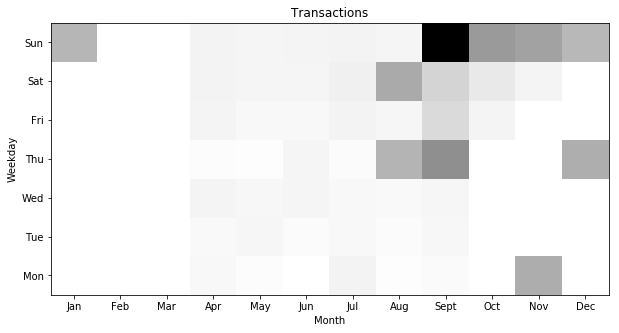

In [293]:
def plot_calendar_heatmap(ax, date_groups):
    ax.pcolor(date_groups, cmap='Greys')
    ax.set_xlabel('Month')
    ax.set_ylabel('Weekday')
    ax.set_yticks(np.arange(7)+0.5)
    ax.set_yticklabels(['Mon', 'Tue', 'Wed','Thu','Fri','Sat','Sun'])
    ax.set_xticks(np.arange(12)+0.5)
    ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec'])
    
date_groups[2.0]=0
date_groups[3.0]=0 # Missing data for Feb. and Mar.
date_groups=date_groups.fillna(0)
date_groups = date_groups.sort_index(axis=1)
f, ax =plt.subplots(1,1,figsize=(10,5))
plot_calendar_heatmap(ax, date_groups)
ax.set_title('Transactions')
# Sunday has significantly higher transactions.

Further analysis of the FACT_Sites_2017.csv yielded sales data. Sales were grouped by date and weekday and plotted on a heatmap. The data revealed that the majority of the transactions occurred during the Fall, specifically on Sundays in September, again corresponding to the football season.

# Menu items

In [5]:
%%time
fact_reader = pd.read_csv('data/FACT_Sites_2017.csv', chunksize=5000, 
                          skip_blank_lines=True, error_bad_lines=False,
                          parse_dates=['transDatetime'], infer_datetime_format=True,
                          iterator=True,
                          usecols=['Location','transDatetime','recordID']
                         )
menu_location_groups = pd.DataFrame()
menu_month_groups = pd.DataFrame()
for chunk in fact_reader:
    i += 1
    #Investigate location with menu items
    menu_merged_chunk = pd.merge(chunk, menu_data, how='inner', left_on='recordID', right_on='menuItemID')
    menu_location_group_chunk = menu_merged_chunk.groupby(['Location', 'menuItemName1']).size().unstack()
    menu_location_groups = menu_location_groups.add(menu_location_group_chunk, fill_value=0)
    menu_month_group_chunk = menu_merged_chunk.groupby([menu_merged_chunk.transDatetime.dt.month, 'menuItemName1']).size().unstack()
    menu_month_groups = menu_month_groups.add(menu_month_group_chunk, fill_value=0)

CPU times: user 1min 50s, sys: 21.2 s, total: 2min 11s
Wall time: 2min 11s


In [31]:
menu_merged_chunk.groupby(['recordID', 'menuItemName1']).size().to_dict()

{(6281797.0, 'SOUV CUP '): 7,
 (6301652.0, 'BTL DASANI'): 15,
 (6301660.0, 'BTL COKE'): 3,
 (6301661.0, 'BTL DIET COKE'): 1,
 (6301663.0, 'BTL SPRITE'): 1,
 (6301700.0, 'CAN16 GOOSE IPA'): 5,
 (6301702.0, 'CAN16 CORONA'): 1,
 (6301703.0, 'CAN16 FAT TIRE'): 1,
 (6301704.0, 'CAN16 BUD LT LM'): 6,
 (6301707.0, 'CAN16 HEINEKEN'): 1,
 (6301708.0, 'CAN16 SWEETWATER'): 2,
 (6301710.0, 'CAN16 LANDSHARK'): 2,
 (6301711.0, 'CAN16 ANGRY ORCH'): 3,
 (6301713.0, 'CAN16 MICH ULTRA'): 1,
 (6301714.0, 'CAN16 DOMESTIC'): 2,
 (6301715.0, 'CAN16 PREMIUM'): 2,
 (6301717.0, 'CAN16 COORS LT'): 3,
 (6301718.0, 'CAN16 BUDWEISER'): 6,
 (6301719.0, 'CAN16 BUD LIGHT'): 11,
 (6301720.0, 'CAN16 MILLER LT'): 6,
 (6301721.0, 'CAN14.9 STELLA '): 5,
 (6301722.0, 'CAN16 BLUEMOON'): 2,
 (6301723.0, 'CAN16 SHOCK TOP'): 2,
 (6301751.0, 'CAN24 CORONA'): 1,
 (6301753.0, 'CAN24 YUENGLING'): 3,
 (6301754.0, 'CAN24 COORS LT'): 1,
 (6301755.0, 'CAN24 MILLER LT'): 6,
 (6301802.0, 'CAN25 BUD'): 4,
 (6301805.0, 'CAN25 BUD LIGHT'):

In [509]:
idx = menu_location_groups.idxmax(axis=1)
maxvalue = menu_location_groups.max(axis=1)
menu_location_favorite = pd.DataFrame({'Favorite':idx, 'Sales':maxvalue})
menu_location_favorite = menu_location_favorite.sort_values('Sales', ascending=False)
menu_location_favorite[menu_location_favorite.Sales>10000]

,Favorite,Sales
Location,,
103 CHICKS & PTS,CRAB FRIES,105418.0
148 TONY LUKES,TONY L STEAK,54510.0
404 BULLS BBQ,BULLS SANDWICH,31113.0
101 CAMPS STK/BR,CAMPOS STEAK,26789.0
319CP CHCK & PTS,CRAB FRIES,20680.0
135 HATFIELD GRL,JUMBO HOT DOG,19126.0
106 S PHILLY MRK,HOT DOG,18850.0
110 PIZZA/CRMRY,HELMET CUP,16626.0
204 PIZZA/CRMRY,HELMET CUP,16166.0


## Cluster Menu items based on their sales in different location 
## (Compare with Apriori???)

The Apriori Basket Analysis result can be further validated by the unsupervised machine learning. Here we used KMeans method to cluster all items based on their sales in 196 different locations as well as different date. Items likely to be in one basket should have similar profile of selling location and date. 
We firstly clustered the items from the locations and the number of clusters were selected from the curve plot of silhouette scores. These 1002 items were classified into 5 clusters labeled from 0 to 4. The frequent itemsets were supposed to appear within each cluster and it dramatically reduced the calculation of the PCY.


We noticed that many items have NA value with the location. To reduce the calculation of PCY, we firstly classified the 196 locations into N clusters from their selling data. Then for each cluster, the items with transaction number not equal to NA were selected as candicates and PCY was applied for each cluster. 



In [9]:
%%time
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score
def classify_kmeans(data, n_clusters=5, stdout=True):
    km_n = KMeans(n_clusters=n_clusters)
    km_n.fit(data)
    predict_labels = km_n.fit_predict(data)
    sc = silhouette_score(data, predict_labels)
    if stdout==True:
        print("Inertia for KMeans with {0:d} clusters = {1:f} ".format(n_clusters, km_n.inertia_))
        print("Silhouette Score for KMeans with {0:d} clusters = {1:f}".format(n_clusters,sc))
    return (sc, predict_labels)
    
def plot_reduction(ax, data_2d, labels=None, centers=None):
    if labels is not None:
        ax.scatter(data_2d[:,0],data_2d[:,1],c=labels, cmap='Set1', linewidth=0)
    else:
        ax.scatter(data_2d[:,0],data_2d[:,1],cmap='Set1', linewidth=0)
    if centers is not None:
        ax.scatter(centers[:,0],centers[:,1],marker='x', s=50, linewidths=3,color='k')

CPU times: user 537 ms, sys: 320 ms, total: 857 ms
Wall time: 1.81 s


In [10]:
menu_location_cluster = menu_location_groups.fillna(0)
menu_location_cluster = menu_location_cluster.T
menu_location_cluster.shape

(1002, 196)

In [11]:
sc=classify_kmeans(menu_location_cluster, n_clusters=5)
##Very bad...

Inertia for KMeans with 5 clusters = 15422296886.366535 
Silhouette Score for KMeans with 5 clusters = 0.871442


In [13]:
svd = TruncatedSVD(n_components=2)
svd.fit(menu_location_cluster)  
data_2d = svd.fit_transform(menu_location_cluster)
kmeans_5 = KMeans(n_clusters=5)
kmeans_5.fit(data_2d)
cluster_labels = kmeans_5.predict(data_2d)
centers = kmeans_5.cluster_centers_

In [15]:
cluster_labels

array([2, 2, 2, ..., 2, 2, 2], dtype=int32)

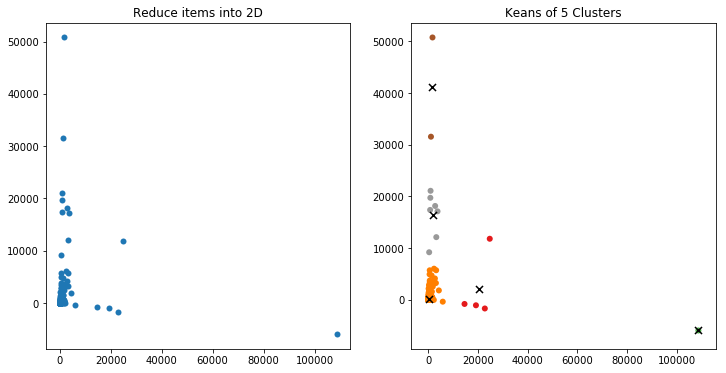

In [14]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
plot_reduction(ax1, data_2d)
ax1.set_title('Reduce items into 2D')
plot_reduction(ax2, data_2d, cluster_labels, centers)
ax2.set_title('Keans of 5 Clusters')

In [521]:
menu_month_groups = menu_month_groups.fillna(0)
idx = menu_month_groups.idxmax(axis=1)
maxvalue = menu_month_groups.max(axis=1)
menu_month_favorite = pd.DataFrame({'Favorite':idx, 'Sales':maxvalue})
menu_month_favorite = menu_month_favorite.sort_index(axis=1)
menu_month_favorite

,Favorite,Sales
transDatetime,,
1,CP Fry Cup,10324.0
4,$1.00 DOG,43912.0
5,BTL DASANI,27547.0
6,BTL DASANI,44233.0
7,BTL DASANI,57491.0
8,BTL DASANI,38725.0
9,20oz Water,49330.0
10,CP Fry Cup,14867.0
11,CP Fry Cup,20234.0


In [538]:
menu_month_cluster = menu_month_groups.T
menu_month_cluster[2]=0
menu_month_cluster[3]=0 #add column for Feb. and Mar.
menu_month_cluster = menu_month_cluster.sort_index(axis=1)
menu_month_cluster.head(3)

transDatetime,1,2,3,4,5,6,7,8,9,10,11,12
menuItemName1,,,,,,,,,,,,
$1.00 DOG,0.0,0,0,43912.0,22790.0,514.0,812.0,562.0,9956.0,0.0,0.0,0.0
$10 DINNER,0.0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
$3 LUNCH,0.0,0,0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0


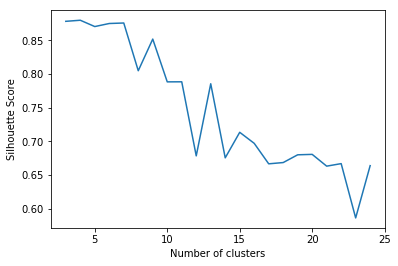

In [571]:
sc_dict = {}
label_dict = {}
for cluster_num in range(3, 25):
    (sc, predict_label) =  classify_kmeans(menu_month_cluster, n_clusters=cluster_num,stdout=False)
    sc_dict[cluster_num] = sc
    label_dict[cluster_num] = predict_label
    
plt.plot(list(sc_dict.keys()), list(sc_dict.values()))
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()
#12 clusters seems to be a good choice which makes sense.

In [589]:
def plot_heatmap(ax, data, labels):
    data_with_cluster = data.copy()
    data_with_cluster['cluster'] = labels
    data_with_cluster = data_with_cluster.sort_values('cluster')
    data_no_cluster = data_with_cluster[data_with_cluster.columns[:-1]]
    ax.pcolor(data_no_cluster, cmap='Greys', alpha=1)
    ax.set_xlim(xmax=data_no_cluster.shape[1])
    ax.set_ylim(ymax=data_no_cluster.shape[0])
    ax.set_xlabel('Month')
    ax.set_ylabel('Items')
    ax.set_xticks(np.arange(data_no_cluster.shape[1])+0.5)
    ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec'], rotation=90)

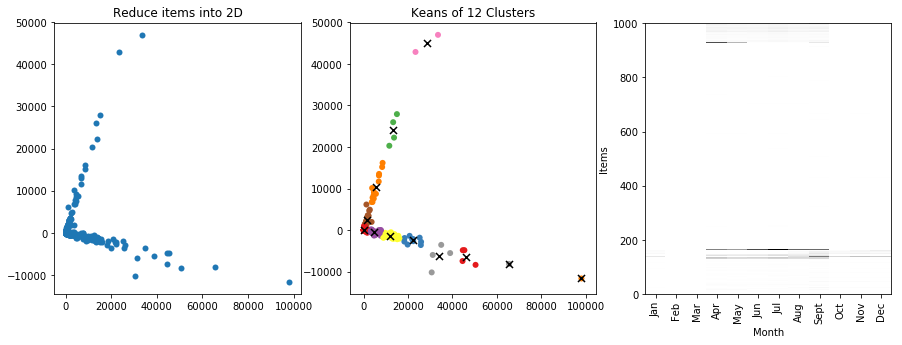

In [590]:
svd = TruncatedSVD(n_components=2)
svd.fit(menu_month_cluster)  
data_2d = svd.fit_transform(menu_month_cluster)
kmeans_12 = KMeans(n_clusters=12)
kmeans_12.fit(data_2d)
cluster_labels = kmeans_12.predict(data_2d)
centers = kmeans_12.cluster_centers_
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
plot_reduction(ax1, data_2d)
ax1.set_title('Reduce items into 2D')
plot_reduction(ax2, data_2d, cluster_labels, centers)
ax2.set_title('Keans of 12 Clusters')
plot_heatmap(ax3, menu_month_cluster, label_dict[12])
#weird clustering...
#Most of products are sell better between April to September.

# Tenders 

In [593]:
%%time
tender_location_groups = pd.DataFrame()
fact_reader = pd.read_csv('data/FACT_Sites_2017.csv', chunksize=5000, 
                          skip_blank_lines=True, error_bad_lines=False,
                          iterator=True, dtype={},
                          usecols=['Location','recordID']
                         )
for chunk in fact_reader:
    i += 1
    #Investigate location with menu items
    tender_merged_chunk = pd.merge(chunk, tender_data, how='inner', left_on='recordID', right_on='tenderMediaID')
    tender_location_group_chunk = tender_merged_chunk.groupby(['Location', 'name']).size().unstack()
    tender_location_groups = tender_location_groups.add(tender_location_group_chunk, fill_value=0)

CPU times: user 2min 10s, sys: 28.4 s, total: 2min 39s
Wall time: 2min 45s


In [600]:
idx = tender_location_groups.idxmax(axis=1)
maxvalue = tender_location_groups.max(axis=1)
tender_location_favorite = pd.DataFrame({'Tender':idx, 'Transactions':maxvalue})
tender_location_favorite = tender_location_favorite.sort_values('Transactions', ascending=False)
tender_location_favorite[(tender_location_favorite.Tender!='CASH') & (tender_location_favorite.Tender!='CASH ')]
#Speed up checking by facilate the checking with the most popular tender medias for each location.

,Tender,Transactions
Location,,
954 DC CON/IN ST,SVC REDEEM,57784.0
953 PITCHERS BAR,SVC REDEEM,22352.0
951 DC BFFT/DOUT,SVC REDEEM,21471.0
902 SCORBRD LWR,VISA,12314.0
208B BREWERY,VISA,8118.0
450 BRWYTWN BTTL,VISA,7476.0
430 BREWTOWN,VISA,6464.0
CB25 E CLUB BAR,VISA,5876.0
CB19 E CLUB BAR,VISA,5404.0
